# Bike-Sharing Dataset

The [Bike-Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. The dataset contains 14 features with information about the day-type, e.g., month, hour, which day of the week, whether it is working-day, and the weather conditions, e.g., temperature, humidity, wind speed, etc. The target variable is the number of bike rentals per hour. The dataset contains 17,379 instances. 

In [2]:
import effector
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2024-03-28 17:24:36.392080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 17:24:37.795745: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-28 17:24:37.795860: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-03-28 17:24:37.795868: W tensorflow/comp

## Preprocess the data

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bike_sharing_dataset = fetch_ucirepo(id=275) 
  
# data (as pandas dataframes) 
X = bike_sharing_dataset.data.features 
y = bike_sharing_dataset.data.targets 
  
# metadata 
print(bike_sharing_dataset.metadata) 
  
# variable information 
print(bike_sharing_dataset.variables) 

{'uci_id': 275, 'name': 'Bike Sharing', 'repository_url': 'https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/275/data.csv', 'abstract': 'This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 17389, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['cnt'], 'index_col': ['instant'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C5W894', 'creators': ['Hadi Fanaee-T'], 'intro_paper': {'title': 'Event labeling combining ensemble detectors and background knowledge', 'authors': 'Hadi Fanaee-T, João Gama', 'published_in': 'Progress in Artificial Intelli

In [4]:
X = X.drop(["dteday", "atemp"], axis=1)

In [5]:
X.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0


In [6]:
# load dataset
# df = pd.read_csv("./../data/Bike-Sharing-Dataset/hour.csv")

# drop columns
# df = df.drop(["instant", "dteday", "casual", "registered", "atemp"], axis=1)

In [7]:
print("Design matrix shape: {}".format(X.shape))
print("---------------------------------")
for col_name in X.columns:
    print("Feature: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(X[col_name].unique()), X[col_name].mean(), X[col_name].std(), X[col_name].min(), X[col_name].max()))
    
print("\nTarget shape: {}".format(y.shape))
print("---------------------------------")
for col_name in y.columns:
    print("Target: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(y[col_name].unique()), y[col_name].mean(), y[col_name].std(), y[col_name].min(), y[col_name].max()))

Design matrix shape: (17379, 11)
---------------------------------
Feature: season         , unique:    4, Mean:   2.50, Std:   1.11, Min:   1.00, Max:   4.00
Feature: yr             , unique:    2, Mean:   0.50, Std:   0.50, Min:   0.00, Max:   1.00
Feature: mnth           , unique:   12, Mean:   6.54, Std:   3.44, Min:   1.00, Max:  12.00
Feature: hr             , unique:   24, Mean:  11.55, Std:   6.91, Min:   0.00, Max:  23.00
Feature: holiday        , unique:    2, Mean:   0.03, Std:   0.17, Min:   0.00, Max:   1.00
Feature: weekday        , unique:    7, Mean:   3.00, Std:   2.01, Min:   0.00, Max:   6.00
Feature: workingday     , unique:    2, Mean:   0.68, Std:   0.47, Min:   0.00, Max:   1.00
Feature: weathersit     , unique:    4, Mean:   1.43, Std:   0.64, Min:   1.00, Max:   4.00
Feature: temp           , unique:   50, Mean:   0.50, Std:   0.19, Min:   0.02, Max:   1.00
Feature: hum            , unique:   89, Mean:   0.63, Std:   0.19, Min:   0.00, Max:   1.00
Feature: wind

Feature analysis:

| Feature      | Description                              | Value Range                                           |
|--------------|------------------------------------------|-------------------------------------------------------|
| season       | season                                   | 1: winter, 2: spring, 3: summer, 4: fall              |
| yr           | year                                     | 0: 2011, 1: 2012                                      |
| mnth         | month                                    | 1 to 12                                               |
| hr           | hour                                     | 0 to 23                                               |
| holiday      | whether the day is a holiday or not      | 0: no, 1: yes                                         |
| weekday      | day of the week                          | 0: Sunday, 1: Monday, …, 6: Saturday                  |
| workingday   | whether the day is a working day or not  | 0: no, 1: yes                                         |
| weathersit   | weather situation                        | 1: clear, 2: mist, 3: light rain, 4: heavy rain       |
| temp         | temperature                              | values in [0.02, 1.00], with mean: 0.50 and std: 0.19 |
| hum          | humidity                                 | values in [0.00, 1.00], with mean: 0.63 and std: 0.19 |
| windspeed    | wind speed                               | values in [0.00, 0.85], with mean: 0.19 and std: 0.12 |


Target variable:

| Target       | Description                            | Value Range                                          |
|--------------|----------------------------------------|------------------------------------------------------|
| cnt          | bike rentals per hour                  | values in [1, 977] with mean: 189.46 and std: 181.39 |


In [8]:
def preprocess(X, y):
    # Standarize X
    X_df = X
    x_mean = X_df.mean()
    x_std = X_df.std()
    X_df = (X_df - X_df.mean()) / X_df.std()

    # Standarize Y
    Y_df = y
    y_mean = Y_df.mean()
    y_std = Y_df.std()
    Y_df = (Y_df - Y_df.mean()) / Y_df.std()
    return X_df, Y_df, x_mean, x_std, y_mean, y_std

# shuffle and standarize all features
X_df, Y_df, x_mean, x_std, y_mean, y_std = preprocess(X, y)

In [9]:
def split(X_df, Y_df):
    # shuffle indices
    indices = X_df.index.tolist()
    np.random.shuffle(indices)
    
    # data split
    train_size = int(0.8 * len(X_df))
    
    X_train = X_df.iloc[indices[:train_size]]
    Y_train = Y_df.iloc[indices[:train_size]]
    X_test = X_df.iloc[indices[train_size:]]
    Y_test = Y_df.iloc[indices[train_size:]]
    
    return X_train, Y_train, X_test, Y_test

# train/test split
X_train, Y_train, X_test, Y_test = split(X_df, Y_df)


## Fit a Neural Network

In [10]:
# Train - Evaluate - Explain a neural network
model = keras.Sequential([
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae", keras.metrics.RootMeanSquaredError()])
model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1)
model.evaluate(X_train, Y_train, verbose=1)
model.evaluate(X_test, Y_test, verbose=1)


2024-03-28 17:24:54.274872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-28 17:24:54.429935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-28 17:24:54.430254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-28 17:24:54.431282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/20


2024-03-28 17:24:55.960441: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x70a86c4aa520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-28 17:24:55.960460: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-03-28 17:24:55.983708: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-28 17:24:56.214219: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-28 17:24:56.298082: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 [==============================] - 3s 5ms/step - loss: 0.5113 - mae: 0.5164 - root_mean_squared_error: 0.7150
Epoch 2/20
28/28 [==============================] - 0s 4ms/step - loss: 0.3653 - mae: 0.4330 - root_mean_squared_error: 0.6044
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 0.2810 - mae: 0.3716 - root_mean_squared_error: 0.5301
Epoch 4/20
28/28 [==============================] - 0s 4ms/step - loss: 0.2122 - mae: 0.3225 - root_mean_squared_error: 0.4606
Epoch 5/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1509 - mae: 0.2682 - root_mean_squared_error: 0.3884
Epoch 6/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1262 - mae: 0.2467 - root_mean_squared_error: 0.3553
Epoch 7/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0983 - mae: 0.2217 - root_mean_squared_error: 0.3135
Epoch 8/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0751 - mae: 0.1886 - root_mean_squared_error: 0.

[0.06518784910440445, 0.17260313034057617, 0.25531911849975586]

We train a deep fully-connected Neural Network with 3 hidden layers for \(20\) epochs. 
The model achieves a root mean squared error on the test of about $0.24$ units, that corresponds to approximately \(0.26 * 181 = 47\) counts.

## Explain

We will focus on the feature `temp` (temperature) because its global effect is quite heterogeneous and the heterogeneity can be further explained using regional effects.

In [11]:
def model_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_forward(x):
    return model(x).numpy().squeeze()


In [12]:
scale_x = {"mean": x_mean.iloc[3], "std": x_std.iloc[3]}
scale_y = {"mean": y_mean.iloc[0], "std": y_std.iloc[0]}
scale_x_list =[{"mean": x_mean.iloc[i], "std": x_std.iloc[i]} for i in range(len(x_mean))]
feature_names = X_df.columns.to_list()
target_name = "bike-rentals"

## Global Effect

We will first analyze the global effect of the feature `hour` on the target variable `bike-rentals`, using the PDP and RHALE methods.

### PDP 

In [13]:
pdp = effector.PDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=300)

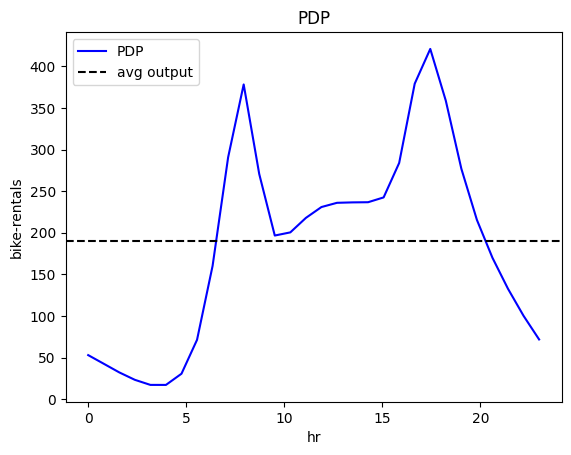

In [14]:
pdp.plot(feature=3, centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

### RHALE

In [15]:
rhale = effector.RHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)

Degrees of freedom <= 0 for slice
invalid value encountered in true_divide
invalid value encountered in true_divide


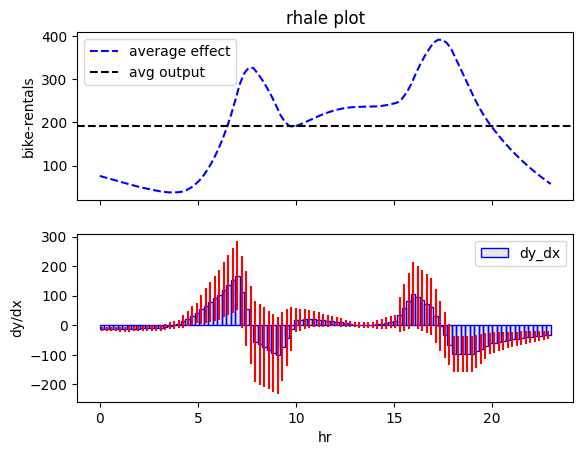

In [16]:
rhale.plot(feature=3, heterogeneity="std", centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

### Conclusion

The global effect of feature `hour` on the target variable `bike-rentals` shows two high peaks, one at around 8:00 and another at around 17:00, which probably corresponds to the morning and evening commute hours of the working days. However, the effect is quite heterogeneous. For this reason, we will analyze the regional effects which may explain the underlying heterogeneity.

## Regional Effect

### RegionalRHALE

In [17]:
# Regional RHALE
regional_rhale = effector.RegionalRHALE(
    data=X_train.to_numpy(),
    model=model_forward,
    model_jac=model_jac,
    cat_limit=10,
    feature_names=feature_names,
    nof_instances="all"
)

regional_rhale.fit(
    features=3,
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.2,
    binning_method=effector.binning_methods.Greedy(init_nof_bins=100, min_points_per_bin=100, discount=1., cat_limit=10),
    max_depth=2,
    nof_candidate_splits_for_numerical=10,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
)

100%|██████████| 1/1 [00:09<00:00,  9.37s/it]


In [18]:
regional_rhale.show_partitioning(features=3, only_important=True, scale_x_list=scale_x_list)

Feature 3 - Full partition tree:
Node id: 0, name: hr, heter: 5.97 || nof_instances: 13903 || weight: 1.00
        Node id: 1, name: hr | workingday == 0.0, heter: 2.41 || nof_instances:  4385 || weight: 0.32
        Node id: 2, name: hr | workingday != 0.0, heter: 4.54 || nof_instances:  9518 || weight: 0.68
--------------------------------------------------
Feature 3 - Statistics per tree level:
Level 0, heter: 5.97
        Level 1, heter: 3.86 || heter drop: 2.11 (35.31%)


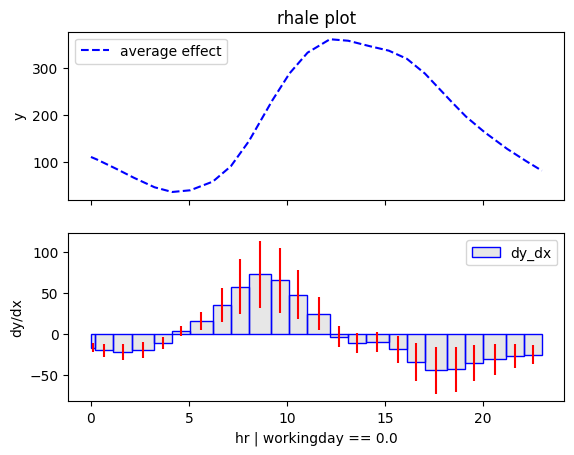

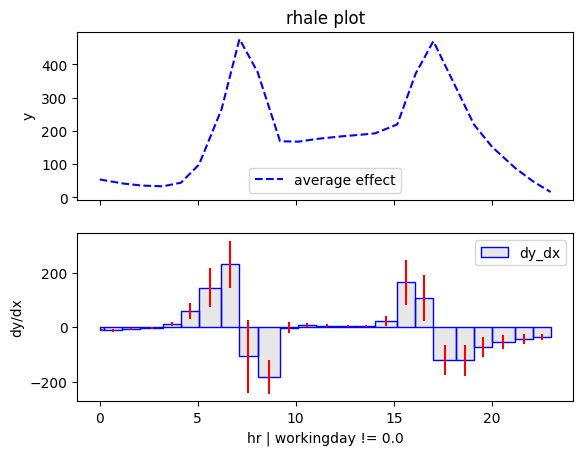

In [19]:
regional_rhale.plot(feature=3, node_idx=1, heterogeneity=True, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)
regional_rhale.plot(feature=3, node_idx=2, heterogeneity=True, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

### RegionalPDP

In [20]:
regional_pdp = effector.RegionalPDP(
    data=X_train.to_numpy(),
    model=model_forward,
    cat_limit=10,
    feature_names=feature_names,
    nof_instances="all"
)

regional_pdp.fit(
    features=3,
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.1,
    max_depth=2,
    nof_candidate_splits_for_numerical=5,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
    nof_instances=1000
)

100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


In [21]:
regional_pdp.show_partitioning(features=3, only_important=True, scale_x_list=scale_x_list)

Feature 3 - Full partition tree:
Node id: 0, name: hr, heter: 0.57 || nof_instances: 13903 || weight: 1.00
        Node id: 1, name: hr | workingday == 1.0, heter: 0.43 || nof_instances:  9518 || weight: 0.68
                Node id: 3, name: hr | workingday == 1.0 and yr == 1.0, heter: 0.39 || nof_instances:  4733 || weight: 0.34
                Node id: 4, name: hr | workingday == 1.0 and yr != 1.0, heter: 0.31 || nof_instances:  4785 || weight: 0.34
        Node id: 2, name: hr | workingday != 1.0, heter: 0.46 || nof_instances:  4385 || weight: 0.32
                Node id: 5, name: hr | workingday != 1.0 and yr == 1.0, heter: 0.47 || nof_instances:  2202 || weight: 0.16
                Node id: 6, name: hr | workingday != 1.0 and yr != 1.0, heter: 0.33 || nof_instances:  2183 || weight: 0.16
--------------------------------------------------
Feature 3 - Statistics per tree level:
Level 0, heter: 0.57
        Level 1, heter: 0.44 || heter drop: 0.13 (22.38%)
                Level 2,

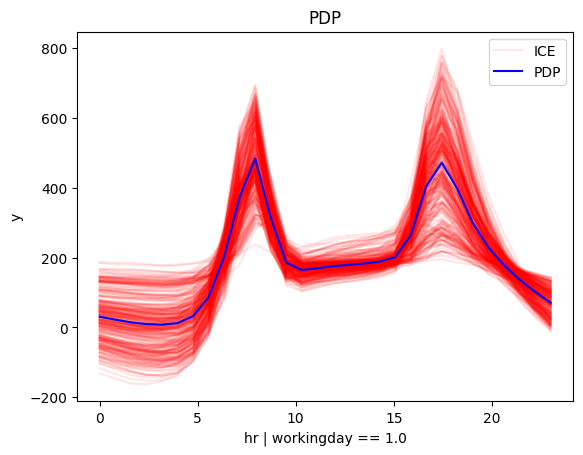

In [22]:
regional_pdp.plot(feature=3, node_idx=1, heterogeneity="ice", centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

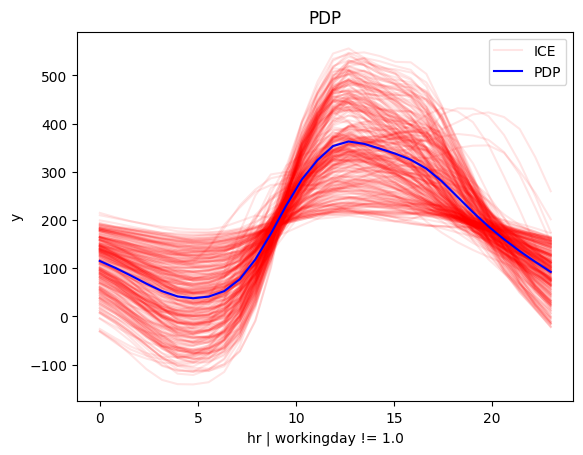

In [23]:
regional_pdp.plot(feature=3, node_idx=2, heterogeneity="ice", centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

### Conclusion

The both PDP and RHALE regional effect reveal two distinct explanations; one for the working days and another for the non-working days. For the working days, the effect is quite similar to the global effect (unfortunately, working ways dominate our life), with two high peaks at around 8:00 and 17:00. However, for the non-working days, the effect is quite different, with a single high peak at around 13:00 which probably corresponds to sightseeing and leisure activities.